# VQE with Qiskit

This is the current version of my VQE. Ideally this should not be in a Jupyter notebook, of course. But this form is convenient to play with the different parts of the Qiskit's infrastructure and see how they work.

In [1]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import Zero, VarFormBased
from qiskit.aqua.operators import MatrixOperator, TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms.adaptive import VQE

In [3]:
from scipy.sparse import *
from scipy import *

## VQE Settings

In [4]:
num_qubits = 2

## Variational Form

In [5]:
num_var_params = 3
var_form_depth = 1
optimal_params = [-0.386244, 0.317799, -0.416888] # from exact solution
initial_params = [0.0, 0.0, 0.0]
var_form_depth2 = 2
initial_params2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0] # deeper ansatz / layer

In [6]:
class SchwingerAnsatz(VariationalForm):
    """ Variational Layer from Martin's Paper """
    
    CONFIGURATION = {
        'name': 'Schwinger Ansatz',
        'description': 'Variational Form for Schwinger VQE',
        'input_schema': {
            '$schema': 'http://json-schema.org/draft-07/schema#',
            'id': 'schwinger_schema',
            'type': 'object',
            'properties': {
                'depth': {
                    'type': 'integer',
                    'default': 3,
                    'minimum': 1
                },
                'entangler_map': {
                    'type': ['array', 'null'],
                    'default': None
                },
                'entanglement_gate': {
                    'type': 'string',
                    'default': 'cx',
                    'enum': ['cx']
                },
            },
            'additionalProperties': False
        },
        'depends': [
            {
                'pluggable_type': 'initial_state',
                'default': {
                    'name': 'ZERO',
                }
            },
        ],
    }
    
    def __init__(self, depth=3, entangler_map=None, initial_state=None):
        """
        Constructor.
        Args:
            depth (int) : number of rotation layers
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                             [source, target], or None for full entanglement.
                             Note that the order is the list is the order of
                             applying the two-qubit gate.
            initial_state (InitialState): an initial state object
        """
        self.validate(locals())
        super().__init__()
        #_support_parameterized_circuit = True
        # hard-coded, first pass through FIXME
        num_qubits = 2
        num_parameters = 3
        entanglement='full'
        entanglement_gate='cx'
        skip_unentangled_qubits = False
        self._num_qubits = num_qubits 
        self._depth = depth
        if entangler_map is None:
            self._entangler_map = VariationalForm.get_entangler_map(entanglement, num_qubits)
        else:
            self._entangler_map = VariationalForm.validate_entangler_map(entangler_map, num_qubits)
        # determine the entangled qubits
        all_qubits = []
        for src, targ in self._entangler_map:
            all_qubits.extend([src, targ])
        self._entangled_qubits = sorted(list(set(all_qubits)))
        self._initial_state = initial_state
        self._entanglement_gate = entanglement_gate
        self._skip_unentangled_qubits = skip_unentangled_qubits
        # for the first layer
        self._num_parameters = num_parameters
        # for repeated block
        self._num_parameters += num_parameters * (depth-1)
        self._bounds = [(-np.pi, np.pi)] * self._num_parameters
    
    def construct_circuit(self, parameters, q=None):
        """
        Construct the variational form, given its parameters.
        
        Args:
            parameters (numpy.ndarray): circuit parameters
            q (QuantumRegister): Quantum Register for the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit with given `parameters`
            
        Raises:
            ValueError: the number of parameters is incorrect.
        """
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))
        
        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        #
        param_idx = 0
        
        def angle(theta=0., phi=0., lam=0.):
            return [theta, phi, lam]

        for _ in range(self._depth):
            # get variational parameters for this layer
            t0 = parameters[param_idx] # theta-angle values
            t1 = parameters[param_idx+1]
            t2 = parameters[param_idx+2]
            t = [angle(t_i) for t_i in [t0, t1, t2]]
            # Construct circuit
            circuit.u3(*(t[1]), 0)  # u3(*angles, q)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[2]), 1)
            circuit.barrier(q)

        return circuit  

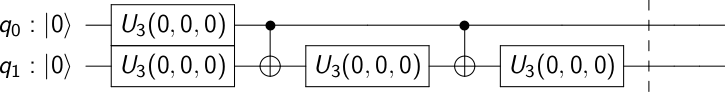

In [7]:
schwinger_form = SchwingerAnsatz(var_form_depth)
vqs_circ = schwinger_form.construct_circuit(initial_params)
vqs_circ.draw(output='latex', scale=0.5)

## Initial State

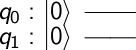

In [8]:
fiducial_state = Zero(num_qubits)
fid_circ = fiducial_state.construct_circuit()
fid_circ.draw(output='latex', scale=0.5)

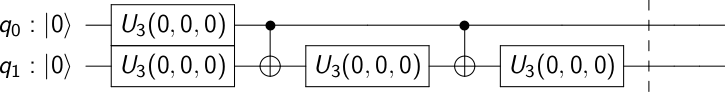

In [9]:
var_form_wavefunction = VarFormBased(schwinger_form, initial_params)
var_form_wavefunction.construct_circuit().draw(output='latex', scale=0.5)

## Hamiltonian

In [10]:
# these correspond to L=2 spatial sites. 
# They have slightly different truncations so that the dimensions of the matrices are the same.

h_even = np.array([
 [-0.20036, 1.19976, 0., 0.],
 [1.19976, 1., 0.848358, 0.],
 [0., 0.848358, 2.20036, 0.848358],
 [0., 0., 0.848358, 3.]
])

h_odd = np.array([
    [1., 0.848358, 0., 0.],
    [0.848358, 2.20036, -0.848358, 0.],
    [0., -0.848358, 3., -0.848358],
    [0., 0., -0.848358, 3.79964]
])

In [11]:
# this is a "switch" :)
h = h_even
# h = h_odd

In [12]:
# Thread on qubit ordering in Qiskit
# https://github.com/Qiskit/qiskit-terra/issues/1148

In [13]:
H_mat = csr_matrix(h)
H_MatrixOperator = MatrixOperator(H_mat)
H_Operator = to_tpb_grouped_weighted_pauli_operator(H_MatrixOperator, 
                                                    TPBGroupedWeightedPauliOperator.sorted_grouping)
print(H_Operator.print_details())

TPB: YY (2)
II	(1.5+0j)
YY	(0.424179+0j)
TPB: XX (2)
IX	(1.0240589999999998+0j)
XX	(0.424179+0j)
TPB: ZZ (3)
IZ	(-0.5+0j)
ZI	(-1.10018+0j)
ZZ	(-0.10017999999999999+0j)
TPB: ZX (1)
ZX	(0.175701+0j)



In [14]:
operator_mode=None
input_circuit=None
backend=None
qr=None
cr=None
use_simulator_operator_mode=False
wave_function=fid_circ
statevector_mode=True

In [15]:
H_circs = H_Operator.construct_evaluation_circuit(operator_mode,
                                        input_circuit,
                                        backend,
                                        qr,
                                        cr,
                                        use_simulator_operator_mode,
                                        wave_function,
                                        statevector_mode)

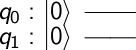

In [16]:
H_circs[0].draw(output='latex', scale=0.5)

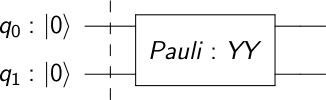

In [17]:
H_circs[1].draw(output='latex', scale=0.5)

## Optimizer

In [18]:
max_trials = 500
optimizer = qiskit.aqua.components.optimizers.SPSA(max_trials)
print(optimizer.setting) 

Optimizer: SPSA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'last_avg': 1, 'save_steps': 1}
-- max_evals_grouped: 1
-- max_trials: 500
-- parameters: [0.62831853 0.1        0.602      0.101      0.        ]
-- skip_calibration: False



## Variational Quantum Simulation
### Extend VQE class to incude statistics in results, or find a way to retrieve statistics from the existing class

Q: where is the counts object in the existing class?

In [19]:
# a callback that can access the intermediate data 
# during the optimization.
# Internally, four arguments are provided as follows 
# the index of evaluation, parameters of variational form,
# evaluated mean, evaluated standard deviation.
def simple_callback(eval_count, parameter_set, mean, std):
    if eval_count % 1 == 0:
        print('Energy evaluation %s returned %4f +/- %4f' % (eval_count, np.real(mean), np.real(std)))

In [20]:
# classVQE(operator, var_form, optimizer, 
# operator_mode=None, initial_point=None, 
# max_evals_grouped=1, 
# aux_operators=None, callback=None, 
# auto_conversion=True)
operator_mode = None
initial_point = initial_params
max_evals_grouped=1              # max number of evaluations performed simultaneously
aux_operators = None
auto_conversion=False
sim = VQE(H_Operator, schwinger_form, optimizer,
          operator_mode,
          initial_point, 
          max_evals_grouped, 
          aux_operators, 
          simple_callback, 
          auto_conversion)

In [21]:
backend = None
use_simulator_operator_mode=False
statevector_mode=True

In [22]:
sim_circs = sim.construct_circuit(initial_params, backend, use_simulator_operator_mode, statevector_mode)

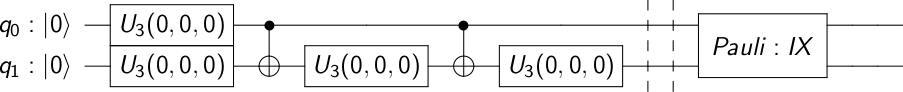

In [23]:
sim_circs[2].draw(output='latex', scale=0.5)

In [24]:
backend_sim = Aer.get_backend('qasm_simulator')

In [25]:
from qiskit.aqua import QuantumInstance
nshots = 1024
my_quantum_instance = QuantumInstance(backend_sim, nshots)

In [26]:
print(my_quantum_instance)


Qiskit Terra version: 0.10.0
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'cu1', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'multiplexer', 'snapshot', 'unitary', 'reset', 'initialize', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None


In [27]:
print(sim.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <__main__.SchwingerAnsatz object at 0x121014588>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x1210ebc50>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x1225ff048>>
-- initial_point: [0.0, 0.0, 0.0]
-- callback: <function simple_callback at 0x1225f3b70>
-- operator: : Representation: tpb grouped paulis, qubits: 2, size: 8, group: 4
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: False
Variational Form: Schwinger Ansatz
-- num_parameters: 3
-- num_qubits: 2
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- depth: 1
-- entangler_map: [[0, 1]]
-- entangled_qubits: [0, 1]
-- initial_state: None
-- entanglement_gate: cx
-- skip_unentangled_qubits: False
Optimizer: SPSA
-- gradient_support_le

In [28]:
res = sim.run(my_quantum_instance)

Energy evaluation 1 returned -0.050911 +/- 0.035138
Energy evaluation 2 returned -0.296491 +/- 0.042010
Energy evaluation 3 returned 0.013586 +/- 0.036250
Energy evaluation 4 returned -0.221706 +/- 0.042568
Energy evaluation 5 returned -0.290479 +/- 0.035207
Energy evaluation 6 returned 0.072967 +/- 0.042472
Energy evaluation 7 returned -0.306164 +/- 0.042728
Energy evaluation 8 returned -0.018948 +/- 0.035439
Energy evaluation 9 returned 0.039769 +/- 0.041923
Energy evaluation 10 returned -0.272969 +/- 0.035696
Energy evaluation 11 returned -0.266676 +/- 0.036863
Energy evaluation 12 returned -0.093815 +/- 0.039057
Energy evaluation 13 returned -0.060268 +/- 0.036767
Energy evaluation 14 returned -0.285517 +/- 0.038649
Energy evaluation 15 returned -0.048169 +/- 0.039136
Energy evaluation 16 returned -0.310054 +/- 0.036366
Energy evaluation 17 returned -0.073505 +/- 0.041934
Energy evaluation 18 returned -0.339924 +/- 0.035834
Energy evaluation 19 returned -0.013822 +/- 0.041452
Energ

Energy evaluation 155 returned -0.969729 +/- 0.028829
Energy evaluation 156 returned -1.014218 +/- 0.035230
Energy evaluation 157 returned -0.924843 +/- 0.037116
Energy evaluation 158 returned -1.035950 +/- 0.029061
Energy evaluation 159 returned -0.977601 +/- 0.034151
Energy evaluation 160 returned -0.945577 +/- 0.028253
Energy evaluation 161 returned -0.949763 +/- 0.029870
Energy evaluation 162 returned -1.049192 +/- 0.032755
Energy evaluation 163 returned -1.040700 +/- 0.029386
Energy evaluation 164 returned -0.949107 +/- 0.034470
Energy evaluation 165 returned -1.006680 +/- 0.030249
Energy evaluation 166 returned -0.966280 +/- 0.032648
Energy evaluation 167 returned -0.977189 +/- 0.034539
Energy evaluation 168 returned -0.946214 +/- 0.029309
Energy evaluation 169 returned -0.964427 +/- 0.033263
Energy evaluation 170 returned -0.968537 +/- 0.031805
Energy evaluation 171 returned -0.970810 +/- 0.033634
Energy evaluation 172 returned -1.005832 +/- 0.029419
Energy evaluation 173 return

Energy evaluation 307 returned -1.045444 +/- 0.031133
Energy evaluation 308 returned -1.017203 +/- 0.030935
Energy evaluation 309 returned -0.902455 +/- 0.033213
Energy evaluation 310 returned -1.032097 +/- 0.030415
Energy evaluation 311 returned -0.944499 +/- 0.031533
Energy evaluation 312 returned -1.028879 +/- 0.031039
Energy evaluation 313 returned -1.035306 +/- 0.030079
Energy evaluation 314 returned -1.016080 +/- 0.030719
Energy evaluation 315 returned -0.986147 +/- 0.031099
Energy evaluation 316 returned -0.979027 +/- 0.031321
Energy evaluation 317 returned -0.993024 +/- 0.028773
Energy evaluation 318 returned -0.939115 +/- 0.033108
Energy evaluation 319 returned -0.960874 +/- 0.028245
Energy evaluation 320 returned -0.968826 +/- 0.034485
Energy evaluation 321 returned -1.071114 +/- 0.031097
Energy evaluation 322 returned -0.969031 +/- 0.029905
Energy evaluation 323 returned -0.936576 +/- 0.031693
Energy evaluation 324 returned -0.961188 +/- 0.031328
Energy evaluation 325 return

Energy evaluation 459 returned -1.006418 +/- 0.030444
Energy evaluation 460 returned -0.964895 +/- 0.031798
Energy evaluation 461 returned -1.038740 +/- 0.029770
Energy evaluation 462 returned -1.006173 +/- 0.033842
Energy evaluation 463 returned -0.973743 +/- 0.031045
Energy evaluation 464 returned -1.029011 +/- 0.031276
Energy evaluation 465 returned -0.984677 +/- 0.034179
Energy evaluation 466 returned -0.989879 +/- 0.028787
Energy evaluation 467 returned -0.985596 +/- 0.028454
Energy evaluation 468 returned -0.987303 +/- 0.033734
Energy evaluation 469 returned -0.995380 +/- 0.029588
Energy evaluation 470 returned -1.032634 +/- 0.031218
Energy evaluation 471 returned -0.966915 +/- 0.034673
Energy evaluation 472 returned -0.971302 +/- 0.027981
Energy evaluation 473 returned -0.969994 +/- 0.032361
Energy evaluation 474 returned -1.041268 +/- 0.029402
Energy evaluation 475 returned -0.988776 +/- 0.029951
Energy evaluation 476 returned -0.994331 +/- 0.030438
Energy evaluation 477 return

Energy evaluation 611 returned -0.993573 +/- 0.031826
Energy evaluation 612 returned -1.035663 +/- 0.031890
Energy evaluation 613 returned -1.011827 +/- 0.034042
Energy evaluation 614 returned -1.037183 +/- 0.028653
Energy evaluation 615 returned -1.030239 +/- 0.030609
Energy evaluation 616 returned -1.002677 +/- 0.032054
Energy evaluation 617 returned -0.972556 +/- 0.031074
Energy evaluation 618 returned -0.989477 +/- 0.031124
Energy evaluation 619 returned -0.987328 +/- 0.031425
Energy evaluation 620 returned -1.031672 +/- 0.030406
Energy evaluation 621 returned -0.988924 +/- 0.034533
Energy evaluation 622 returned -1.019608 +/- 0.029027
Energy evaluation 623 returned -1.037655 +/- 0.031813
Energy evaluation 624 returned -0.967155 +/- 0.030476
Energy evaluation 625 returned -1.011757 +/- 0.031325
Energy evaluation 626 returned -1.010610 +/- 0.030326
Energy evaluation 627 returned -0.991236 +/- 0.029997
Energy evaluation 628 returned -1.007625 +/- 0.032692
Energy evaluation 629 return

Energy evaluation 763 returned -1.059932 +/- 0.031718
Energy evaluation 764 returned -0.976297 +/- 0.029947
Energy evaluation 765 returned -0.973946 +/- 0.029992
Energy evaluation 766 returned -0.951110 +/- 0.034259
Energy evaluation 767 returned -0.972634 +/- 0.033983
Energy evaluation 768 returned -0.984927 +/- 0.029789
Energy evaluation 769 returned -1.032940 +/- 0.033581
Energy evaluation 770 returned -0.967415 +/- 0.029422
Energy evaluation 771 returned -0.996882 +/- 0.033740
Energy evaluation 772 returned -0.990353 +/- 0.030808
Energy evaluation 773 returned -1.020679 +/- 0.030809
Energy evaluation 774 returned -1.012778 +/- 0.032162
Energy evaluation 775 returned -1.012962 +/- 0.032167
Energy evaluation 776 returned -0.998450 +/- 0.031547
Energy evaluation 777 returned -1.059822 +/- 0.032129
Energy evaluation 778 returned -0.997746 +/- 0.032569
Energy evaluation 779 returned -1.064181 +/- 0.034054
Energy evaluation 780 returned -1.033498 +/- 0.029026
Energy evaluation 781 return

Energy evaluation 915 returned -1.023106 +/- 0.030901
Energy evaluation 916 returned -1.006453 +/- 0.030579
Energy evaluation 917 returned -0.944285 +/- 0.031649
Energy evaluation 918 returned -1.013768 +/- 0.030678
Energy evaluation 919 returned -0.987440 +/- 0.031035
Energy evaluation 920 returned -1.049817 +/- 0.029997
Energy evaluation 921 returned -0.998880 +/- 0.031179
Energy evaluation 922 returned -0.985757 +/- 0.031639
Energy evaluation 923 returned -0.973863 +/- 0.028919
Energy evaluation 924 returned -0.997746 +/- 0.033763
Energy evaluation 925 returned -1.008242 +/- 0.032105
Energy evaluation 926 returned -0.993780 +/- 0.029280
Energy evaluation 927 returned -1.051145 +/- 0.029346
Energy evaluation 928 returned -1.012680 +/- 0.032349
Energy evaluation 929 returned -0.952214 +/- 0.031338
Energy evaluation 930 returned -1.002526 +/- 0.031296
Energy evaluation 931 returned -0.968049 +/- 0.034626
Energy evaluation 932 returned -0.969629 +/- 0.029158
Energy evaluation 933 return

In [29]:
res

{'num_optimizer_evals': None,
 'min_val': -1.0092324082031245,
 'opt_params': array([ 0.12398951, -1.18068356,  0.15356187]),
 'eval_time': 308.8051190376282,
 'eval_count': 1051,
 'energy': -1.0092324082031245,
 'eigvals': array([-1.00923241]),
 'min_vector': {'01': 298, '00': 691, '11': 4, '10': 31},
 'eigvecs': array([{'01': 298, '00': 691, '11': 4, '10': 31}], dtype=object)}

In [30]:
sim.get_optimal_vector()

{'01': 298, '00': 696, '11': 1, '10': 29}

In [31]:
sim.get_optimal_cost()

-1.0092324082031245

In [32]:
energy_eval = sim.get_optimal_cost()

In [33]:
energy_eval_err = 0.011

In [34]:
sim._ret['opt_params']

array([ 0.12398951, -1.18068356,  0.15356187])

In [35]:
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])

Energy evaluation 1052 returned -1.026531 +/- 0.031058
Energy evaluation 1053 returned -0.999499 +/- 0.031905
Energy evaluation 1054 returned -0.973244 +/- 0.032028
Energy evaluation 1055 returned -0.969196 +/- 0.032371
Energy evaluation 1056 returned -0.965918 +/- 0.031654


-0.9659175624999999

In [36]:
sim.quantum_instance.backend

<QasmSimulator('qasm_simulator') from AerProvider()>

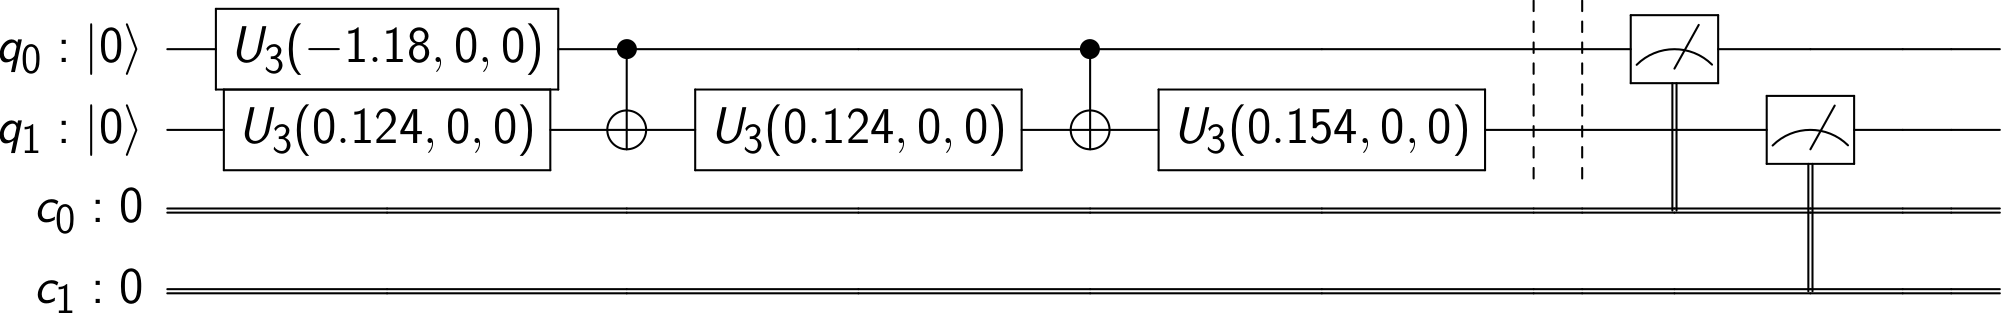

In [37]:
from qiskit.aqua.utils.run_circuits import find_regs_by_name
opt_circ = sim.get_optimal_circuit()
c = ClassicalRegister(opt_circ.width(), name='c')
q = find_regs_by_name(opt_circ, 'q')
opt_circ.add_register(c)
opt_circ.barrier(q)
opt_circ.measure(q, c)
opt_circ.draw(output='latex', filename='example_gate.png', scale=1.0)

In [38]:
latex_source = opt_circ.draw(output='latex_source', filename='example_gate.png', scale=0.5)
print(latex_source)

% \documentclass[preview]{standalone}
% If the image is too large to fit on this documentclass use
\documentclass[draft]{beamer}
% img_width = 4, img_depth = 12
\usepackage[size=custom,height=10,width=39,scale=0.5]{beamerposter}
% instead and customize the height and width (in cm) to fit.
% Large images may run out of memory quickly.
% To fix this use the LuaLaTeX compiler, which dynamically
% allocates memory.
\usepackage[braket, qm]{qcircuit}
\usepackage{amsmath}
\pdfmapfile{+sansmathaccent.map}
% \usepackage[landscape]{geometry}
% Comment out the above line if using the beamer documentclass.
\begin{document}
\begin{equation*}
    \Qcircuit @C=1.0em @R=0.0em @!R {
	 	\lstick{ q_{0} : \ket{0} } & \gate{U_3(-1.18,0,0)} & \ctrl{1} & \qw & \ctrl{1} & \qw \barrier[0em]{1} & \qw \barrier[0em]{1} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\lstick{ q_{1} : \ket{0} } & \gate{U_3(0.124,0,0)} & \targ & \gate{U_3(0.124,0,0)} & \targ & \gate{U_3(0.154,0,0)} & \qw & \qw & \qw & \meter & \qw & \qw

In [39]:
# build an optimized circuit;
# make measurement, retrieve memory
# bootstrap uncertainties

In [40]:
sim.quantum_instance.run_config.shots

1024

In [41]:
sim.quantum_instance.set_config(shots=1024, memory=True)

In [42]:
sim.quantum_instance.run_config

RunConfig(max_credits=10, memory=True, shots=1024)

In [43]:
# takes in results from a single circuit 
# with memory=True, and estimates
# the uncertanities on the probability of each outcome 
# (currently with bootstrap)
# returns outcome:(pba, std) dictionary
def compute_stats(res, invert_qubit_order = False):
    # check that there is a single circuit in the results
    # (ambiguous otherwise)
    assert(len(res.results)==1)
    # generates all possible outcomes given \
    # the number of qubits 
    def _generate_bitstrings(nqubits, invert_qubit_order):
        # (recursive, modifies all_strings in place)
        def _generate_bitstrings_rec(nqubits, all_strings, a_string, irecur): 
            # base
            if irecur == nqubits: 
                all_strings.append(''.join([bit for bit in a_string]))
                return 
            # append 0
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['0'], irecur + 1)
            # append 1
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['1'], irecur + 1)
        all_strings = []
        _generate_bitstrings_rec(nqubits, all_strings, [], 0)
        if (invert_qubit_order): 
        # pesky Qiskit messes up qubit ordering... this may or may not be necessary to translate the results.
            all_strings = [''.join(reversed(bitstring)) for bitstring in all_strings]
        return all_strings
    # bootstrap specific?
    # given ensembles of outcomes and a particular outcome
    # calculates the statistics of that outcome:
    # returns outcome:(pba, std) estimates for the outcome
    def _calc_outcome_stats(ensembles, nshots, outcome):
        cts = np.count_nonzero(ensembles==outcome, axis=0)
        pba = np.mean(cts)/nshots
        std = np.std(cts/nshots, ddof = 1) # use unbiased estimator
        return (pba, std)
    nqubits = int(np.log2(len(res.get_counts(0)))) # pull number of qubits from results
    outcomes = _generate_bitstrings(nqubits, invert_qubit_order)
    mem = res.get_memory(0)
    nshots = sum(list(res.get_counts(0).values()))
    nens = nshots # choose number of ensemles = number of samples
    nsam = nshots
    ensembles = np.random.choice(mem, (nens, nsam))
    stats = map(lambda outcome: (outcome, _calc_outcome_stats(ensembles, nshots, outcome)), outcomes)
    return dict(stats)

In [44]:
sim.quantum_instance.set_config(shots=8*1024, memory=True)
opt_res = sim.quantum_instance.execute(opt_circ)
sim.quantum_instance.set_config(shots=8*1024, memory=False) # reset to no memory! saves resources?

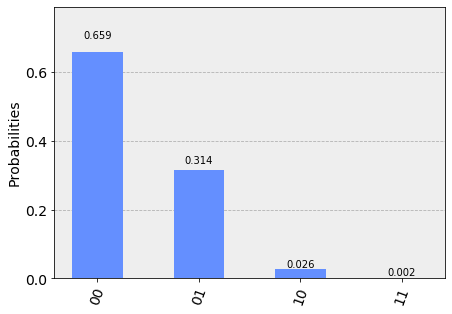

In [45]:
from qiskit.visualization import plot_histogram
plot_histogram(opt_res.get_counts(opt_circ))

In [46]:
measured_coeffs =compute_stats(opt_res, False)

In [47]:
measured_coeffs

{'00': (0.6586602479219437, 0.005321048622351783),
 '01': (0.3136149048805237, 0.005208095810113155),
 '10': (0.025897547602653503, 0.0017553850532887067),
 '11': (0.0018272995948791504, 0.00047652708843728747)}

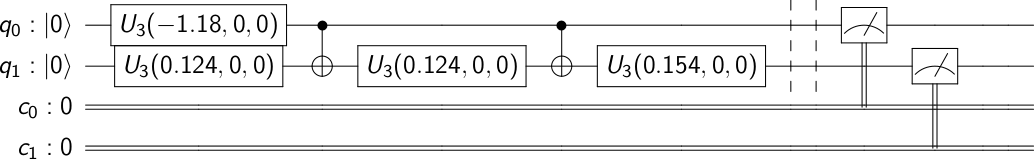

In [48]:
transp_circ = transpile(opt_circ, sim.quantum_instance.backend, optimization_level=3)
transp_circ.draw(output='latex', scale=0.5)

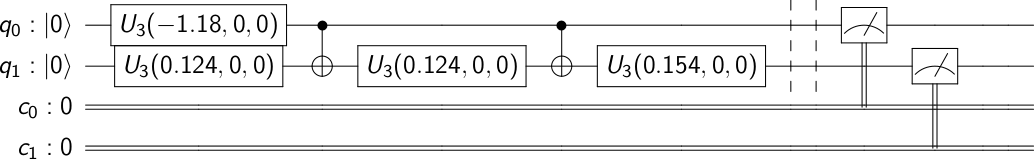

In [49]:
opt_circ.decompose().draw(output='latex', scale=0.5)

In [50]:
# compare with Mathematica's expectations
mathematica_res = -1.01162 # Even
mathematica_res2 = 0.486204 # Odd

# odd coefficients
even_coeffs = [0.669069, 0.305919, 0.023941, 0.00107068]
even_coeffs_at_theta = [0.664109, 0.0236388, 0.309821, 0.00243079]
odd_coeffs = [0.7041621406145364, 0.2582831083289985, 0.03524433188695736, 0.002310419169507747]

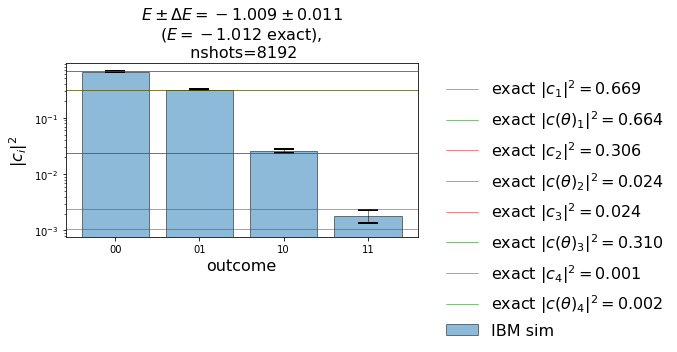

In [51]:
import matplotlib.pyplot as plt
outcomes = list(measured_coeffs.keys())
outcomes_bars = np.arange(len(outcomes))
avgs = [measured_coeffs[outcome][0] for outcome in outcomes]
stds = [measured_coeffs[outcome][1] for outcome in outcomes]
fig, ax = plt.subplots()
ax.bar(outcomes_bars, avgs, yerr=stds, 
       align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$|c_i|^2$', fontsize=16)
ax.set_xlabel(r'outcome', fontsize=16)
ax.set_xticks(outcomes_bars)
ax.set_xticklabels(outcomes)
ax.set_title('$E \\pm \\Delta E = %.3f \\pm %.3f$\n($E = %.3f$ exact),\n nshots=%d' 
             % (energy_eval, energy_eval_err, mathematica_res, 
                sim.quantum_instance.run_config.shots), fontsize=16)
for icoeff in range(len(even_coeffs)):
    ax.axhline(y = even_coeffs[icoeff], color ='red', linewidth = 0.5, 
               label=r'exact $|c_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs[icoeff]))
    ax.axhline(y = even_coeffs_at_theta[icoeff], color ='green', linewidth = 0.5, 
               label=r'exact $|c(\theta)_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs_at_theta[icoeff]))
ax.set_yscale('log')
plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.savefig("even.png", dpi=300)